In [12]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_used import CIFAR10_Net
from torchvision import models
import json
from voting_utils import WeightFinding
from voting_utils import voting
import numpy as np

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [14]:
# Define the directory containing the models
model_directory = 'cinic_various_models_2/'

# Function to load models with "fl" in their name
def load_models(directory, noise_type = 'fl'):
    models_loaded = []

    # List all files in the directory
    files = os.listdir(directory)
    
    for file in tqdm(files):
        if noise_type in file:
            # Load the model
            if 'cifar10_net' in file:
                model = CIFAR10_Net()
            else:
                model = models.vgg16(pretrained = True)
                input_lastLayer = model.classifier[6].in_features
                model.classifier[6] = nn.Linear(input_lastLayer,10)
            model_path = os.path.join(directory, file)
            model.load_state_dict(torch.load(model_path))
            models_loaded.append((file, model))
    
    return models_loaded

# Load the models
fl_models = load_models(model_directory)

# Example usage: Print the names of the loaded models
for file_name, model in fl_models:
    print(f"Loaded model from file: {file_name}")

100%|██████████| 32/32 [00:11<00:00,  2.76it/s]

Loaded model from file: vgg_cifar_fl_1.pt
Loaded model from file: cifar10_net_imagenet_fl_2.pt
Loaded model from file: vgg_imagenet_fl_3.pt
Loaded model from file: cifar10_net_cifar_fl_3.pt
Loaded model from file: cifar10_net_imagenet_fl_3.pt
Loaded model from file: vgg_imagenet_fl_0.pt
Loaded model from file: vgg_cifar_fl_2.pt
Loaded model from file: cifar10_net_cifar_fl_1.pt
Loaded model from file: cifar10_net_imagenet_fl_0.pt
Loaded model from file: vgg_cifar_fl_3.pt
Loaded model from file: cifar10_net_cifar_fl_2.pt
Loaded model from file: cifar10_net_imagenet_fl_1.pt
Loaded model from file: vgg_cifar_fl_0.pt
Loaded model from file: vgg_imagenet_fl_2.pt
Loaded model from file: cifar10_net_cifar_fl_0.pt
Loaded model from file: vgg_imagenet_fl_1.pt


In [15]:
di_models = load_models(model_directory, noise_type = 'di')

# Example usage: Print the names of the loaded models
for file_name, model in di_models:
    print(f"Loaded model from file: {file_name}")
    # You can also print the model structure if needed
    # print(model)

100%|██████████| 32/32 [00:10<00:00,  3.12it/s]

Loaded model from file: cifar10_net_imagenet_di_0.pt
Loaded model from file: vgg_cifar_di_3.pt
Loaded model from file: cifar10_net_cifar_di_3.pt
Loaded model from file: cifar10_net_cifar_di_0.pt
Loaded model from file: vgg_imagenet_di_1.pt
Loaded model from file: cifar10_net_cifar_di_2.pt
Loaded model from file: cifar10_net_imagenet_di_1.pt
Loaded model from file: vgg_imagenet_di_2.pt
Loaded model from file: vgg_cifar_di_2.pt
Loaded model from file: cifar10_net_imagenet_di_3.pt
Loaded model from file: vgg_cifar_di_1.pt
Loaded model from file: vgg_imagenet_di_0.pt
Loaded model from file: vgg_cifar_di_0.pt
Loaded model from file: cifar10_net_cifar_di_1.pt
Loaded model from file: cifar10_net_imagenet_di_2.pt
Loaded model from file: vgg_imagenet_di_3.pt


### Load test data

In [16]:
cinic_directory = 'cinic_10_data'
cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]

batch_size = 512

cifar_test_set = torchvision.datasets.ImageFolder(
    cinic_directory + '/test2/cifar',
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=cinic_mean, std=cinic_std)
    ])
)

imagenet_test_set = torchvision.datasets.ImageFolder(
    cinic_directory + '/test2/imagenet',
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=cinic_mean, std=cinic_std)
    ])
)

In [17]:
fl_just_models = [model for file_name, model in fl_models]
di_just_models = [model for file_name, model in di_models]

fl_just_names = [file_name for file_name, model in fl_models]
di_just_names = [file_name for file_name, model in di_models]

In [18]:
def experiment(n):
    fl_accuracy_dict = {}

    fl_accuracy_dict['loo'] = {}
    fl_accuracy_dict['crh'] = {}
    fl_accuracy_dict['entropy'] = {}
    fl_accuracy_dict['accuracy'] = {}
    fl_accuracy_dict['regression'] = {}
    fl_accuracy_dict['shapley'] = {}
    fl_accuracy_dict['unweighted'] = {}

    di_accuracy_dict = {}

    di_accuracy_dict['loo'] = {}
    di_accuracy_dict['crh'] = {}
    di_accuracy_dict['entropy'] = {}
    di_accuracy_dict['accuracy'] = {}
    di_accuracy_dict['regression'] = {}
    di_accuracy_dict['shapley'] = {}
    di_accuracy_dict['unweighted'] = {}
    for key in fl_accuracy_dict.keys():
        fl_accuracy_dict[key]['borda'] = []
        fl_accuracy_dict[key]['plurality'] = []
        di_accuracy_dict[key]['borda'] = []
        di_accuracy_dict[key]['plurality'] = []

    # LOO weights
    with open('weights_2/loo/fl_loo_weights_borda_ci.json', 'r') as f:
        fl_loo_weights_borda_ci_dict = json.load(f)

    with open('weights_2/loo/di_loo_weights_borda_ci.json', 'r') as f:
        di_loo_weights_borda_ci_dict = json.load(f)

    with open('weights_2/loo/fl_loo_weights_plurality_ci.json', 'r') as f:
        fl_loo_weights_plurality_ci_dict = json.load(f)

    with open('weights_2/loo/di_loo_weights_plurality_ci.json', 'r') as f:
        di_loo_weights_plurality_ci_dict = json.load(f)

    # CRH weights
    with open('weights_2/crh/fl_crh_weights_ci.json', 'r') as f:
        fl_crh_weights_ci_dict = json.load(f)

    with open('weights_2/crh/di_crh_weights_ci.json', 'r') as f:
        di_crh_weights_ci_dict = json.load(f)

    # Entropy weights
    with open('weights_2/entropy/fl_entropy_weights_ci.json', 'r') as f:
        fl_entropy_weights_ci_dict = json.load(f)

    with open('weights_2/entropy/di_entropy_weights_ci.json', 'r') as f:
        di_entropy_weights_ci_dict = json.load(f)

    # Accuracy weights
    with open('weights_2/accuracy/fl_accuracy_weights_ci.json', 'r') as f:
        fl_accuracy_weights_ci_dict = json.load(f)

    with open('weights_2/accuracy/di_accuracy_weights_ci.json', 'r') as f:
        di_accuracy_weights_ci_dict = json.load(f)

    # Regression weights
    with open('weights_2/regression/fl_regression_weights_ci.json', 'r') as f:
        fl_regression_weights_ci_dict = json.load(f)

    with open('weights_2/regression/di_regression_weights_ci.json', 'r') as f:
        di_regression_weights_ci_dict = json.load(f)

    # Shapley weoghts
    with open('weights_2/shapley/fl_shapley_weights_borda_ci.json', 'r') as f:
        fl_shapley_weights_ci_dict = json.load(f)

    with open('weights_2/shapley/di_shapley_weights_borda_ci.json', 'r') as f:
        di_shapley_weights_ci_dict = json.load(f)


    for i in tqdm(range(n)):
        cifar_subset = torch.utils.data.Subset(cifar_test_set, np.random.choice(len(cifar_test_set), 10000, replace=False))
        imagenet_subset = torch.utils.data.Subset(imagenet_test_set, np.random.choice(len(imagenet_test_set), 10000, replace=False))

        cifar_test = torch.utils.data.DataLoader(cifar_subset, batch_size=batch_size, shuffle=False)
        imagenet_test = torch.utils.data.DataLoader(imagenet_subset, batch_size=batch_size, shuffle=False)

        ci_loaders = [cifar_test, imagenet_test]
        c_loader = [cifar_test]
        i_loader = [imagenet_test]

        wf_fl_ci = WeightFinding(fl_just_models, ci_loaders, device)
        wf_fl_ci.models = []
        wf_di_ci = WeightFinding(di_just_models, ci_loaders, device)
        wf_di_ci.models = []

        fl_accuracy_dict['loo']['borda'].append(voting(wf_fl_ci.y_preds, wf_fl_ci.labels, np.array(list(fl_loo_weights_borda_ci_dict.values())), method='borda'))
        fl_accuracy_dict['loo']['plurality'].append(voting(wf_fl_ci.y_preds, wf_fl_ci.labels, np.array(list(fl_loo_weights_plurality_ci_dict.values())), method='plurality'))

        fl_accuracy_dict['crh']['borda'].append(voting(wf_fl_ci.y_preds, wf_fl_ci.labels, np.array(list(fl_crh_weights_ci_dict.values())), method='borda'))
        fl_accuracy_dict['crh']['plurality'].append(voting(wf_fl_ci.y_preds, wf_fl_ci.labels, np.array(list(fl_crh_weights_ci_dict.values())), method='plurality'))

        fl_accuracy_dict['regression']['borda'].append(voting(wf_fl_ci.y_preds, wf_fl_ci.labels, np.array(list(fl_regression_weights_ci_dict.values())), method='borda'))
        fl_accuracy_dict['regression']['plurality'].append(voting(wf_fl_ci.y_preds, wf_fl_ci.labels, np.array(list(fl_regression_weights_ci_dict.values())), method='plurality'))

        fl_accuracy_dict['accuracy']['borda'].append(voting(wf_fl_ci.y_preds, wf_fl_ci.labels, np.array(list(fl_accuracy_weights_ci_dict.values())), method='borda'))
        fl_accuracy_dict['accuracy']['plurality'].append(voting(wf_fl_ci.y_preds, wf_fl_ci.labels, np.array(list(fl_accuracy_weights_ci_dict.values())), method='plurality'))

        fl_accuracy_dict['entropy']['borda'].append(voting(wf_fl_ci.y_preds, wf_fl_ci.labels, np.array(list(fl_entropy_weights_ci_dict.values())), method='borda'))
        fl_accuracy_dict['entropy']['plurality'].append(voting(wf_fl_ci.y_preds, wf_fl_ci.labels, np.array(list(fl_entropy_weights_ci_dict.values())), method='plurality'))

        fl_accuracy_dict['shapley']['borda'].append(voting(wf_fl_ci.y_preds, wf_fl_ci.labels, np.array(list(fl_shapley_weights_ci_dict.values())), method='borda'))
        fl_accuracy_dict['shapley']['plurality'].append(voting(wf_fl_ci.y_preds, wf_fl_ci.labels, np.array(list(fl_shapley_weights_ci_dict.values())), method='plurality'))

        fl_accuracy_dict['unweighted']['borda'].append(voting(wf_fl_ci.y_preds, wf_fl_ci.labels, method='borda'))
        fl_accuracy_dict['unweighted']['plurality'].append(voting(wf_fl_ci.y_preds, wf_fl_ci.labels, method='plurality'))

        di_accuracy_dict['loo']['borda'].append(voting(wf_di_ci.y_preds, wf_di_ci.labels, np.array(list(di_loo_weights_borda_ci_dict.values())), method='borda'))
        di_accuracy_dict['loo']['plurality'].append(voting(wf_di_ci.y_preds, wf_di_ci.labels, np.array(list(di_loo_weights_plurality_ci_dict.values())), method='plurality'))

        di_accuracy_dict['crh']['borda'].append(voting(wf_di_ci.y_preds, wf_di_ci.labels, np.array(list(di_crh_weights_ci_dict.values())), method='borda'))
        di_accuracy_dict['crh']['plurality'].append(voting(wf_di_ci.y_preds, wf_di_ci.labels, np.array(list(di_crh_weights_ci_dict.values())), method='plurality'))

        di_accuracy_dict['regression']['borda'].append(voting(wf_di_ci.y_preds, wf_di_ci.labels, np.array(list(di_regression_weights_ci_dict.values())), method='borda'))
        di_accuracy_dict['regression']['plurality'].append(voting(wf_di_ci.y_preds, wf_di_ci.labels, np.array(list(di_regression_weights_ci_dict.values())), method='plurality'))

        di_accuracy_dict['accuracy']['borda'].append(voting(wf_di_ci.y_preds, wf_di_ci.labels, np.array(list(di_accuracy_weights_ci_dict.values())), method='borda'))
        di_accuracy_dict['accuracy']['plurality'].append(voting(wf_di_ci.y_preds, wf_di_ci.labels, np.array(list(di_accuracy_weights_ci_dict.values())), method='plurality'))

        di_accuracy_dict['entropy']['borda'].append(voting(wf_di_ci.y_preds, wf_di_ci.labels, np.array(list(di_entropy_weights_ci_dict.values())), method='borda'))
        di_accuracy_dict['entropy']['plurality'].append(voting(wf_di_ci.y_preds, wf_di_ci.labels, np.array(list(di_entropy_weights_ci_dict.values())), method='plurality'))

        di_accuracy_dict['shapley']['borda'].append(voting(wf_di_ci.y_preds, wf_di_ci.labels, np.array(list(di_shapley_weights_ci_dict.values())), method='borda'))
        di_accuracy_dict['shapley']['plurality'].append(voting(wf_di_ci.y_preds, wf_di_ci.labels, np.array(list(di_shapley_weights_ci_dict.values())), method='plurality'))

        di_accuracy_dict['unweighted']['borda'].append(voting(wf_di_ci.y_preds, wf_di_ci.labels, method='borda'))
        di_accuracy_dict['unweighted']['plurality'].append(voting(wf_di_ci.y_preds, wf_di_ci.labels, method='plurality'))
    return fl_accuracy_dict, di_accuracy_dict

In [21]:
fl_accuracy_dict, di_accuracy_dict = experiment(20)

100%|██████████| 20/20 [56:10<00:00, 168.52s/it]


In [22]:
#Save the dictionaries
with open('fl_accuracy_dict_ci_2.json', 'w') as f:
    json.dump(fl_accuracy_dict, f)

with open('di_accuracy_dict_ci_2.json', 'w') as f:
    json.dump(di_accuracy_dict, f)

with open('fl_accuracy_dict_ci_2.json', 'r') as f:
    fl_accuracy_dict = json.load(f)

with open('di_accuracy_dict_ci_2.json', 'r') as f:
    di_accuracy_dict = json.load(f)

/tmp/ipykernel_442035/3986542501.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Value', data=fl_plurality_df_melted, palette=palette)


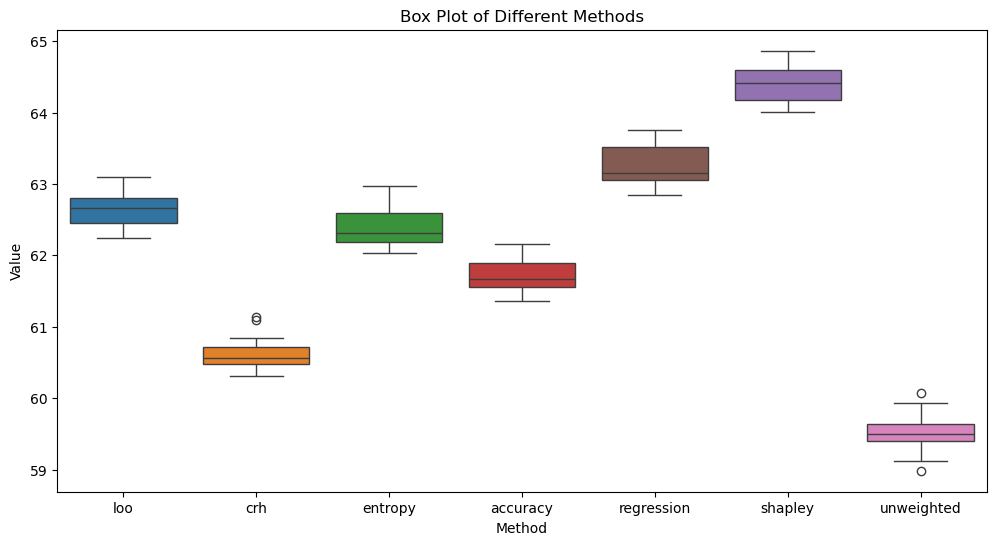

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fl_bordas = {key:fl_accuracy_dict[key]['borda'] for key in fl_accuracy_dict.keys()}
fl_plurality = {key:fl_accuracy_dict[key]['plurality'] for key in fl_accuracy_dict.keys()}

di_bordas = {key:di_accuracy_dict[key]['borda'] for key in di_accuracy_dict.keys()}
di_plurality = {key:di_accuracy_dict[key]['plurality'] for key in di_accuracy_dict.keys()}
fl_bordas_df = pd.DataFrame(fl_bordas)
fl_plurality_df = pd.DataFrame(fl_plurality)

di_bordas_df = pd.DataFrame(di_bordas)
di_plurality_df = pd.DataFrame(di_plurality)

# Assuming the data is stored in a DataFrame named fl_bordas_df
# Melt the DataFrame to a long format suitable for seaborn
fl_bordas_df_melted = fl_bordas_df.melt(var_name='Method', value_name='Value')
fl_plurality_df_melted = fl_plurality_df.melt(var_name='Method', value_name='Value')

# Define a custom color palette
palette = {
    'loo': '#1f77b4',        # Blue
    'crh': '#ff7f0e',        # Orange
    'entropy': '#2ca02c',    # Green
    'accuracy': '#d62728',   # Red
    'shapley': '#9467bd',    # Purple
    'regression': '#8c564b',  # Brown
    'unweighted': '#e377c2'  # Pink
}

# Create a box plot with the custom palette
plt.figure(figsize=(12, 6))
sns.boxplot(x='Method', y='Value', data=fl_plurality_df_melted, palette=palette)
plt.title('Box Plot of Different Methods')
plt.ylabel('Value')
plt.xlabel('Method')
plt.show()

/tmp/ipykernel_442035/161684282.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Value', data=fl_bordas_df_melted, palette=palette)


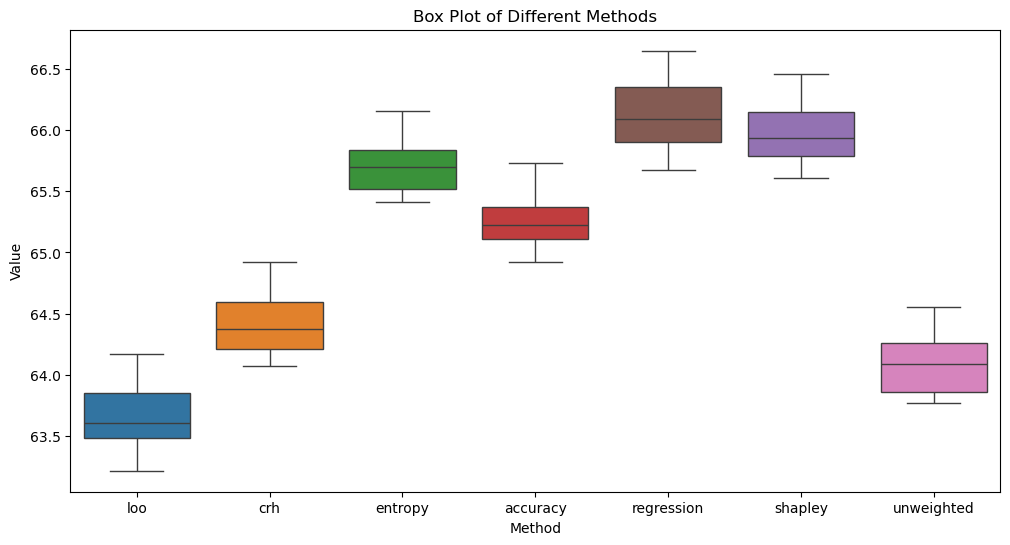

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Method', y='Value', data=fl_bordas_df_melted, palette=palette)
plt.title('Box Plot of Different Methods')
plt.ylabel('Value')
plt.xlabel('Method')
plt.show()

/tmp/ipykernel_442035/732340305.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Value', data=di_bordas_df_melted, palette=palette)


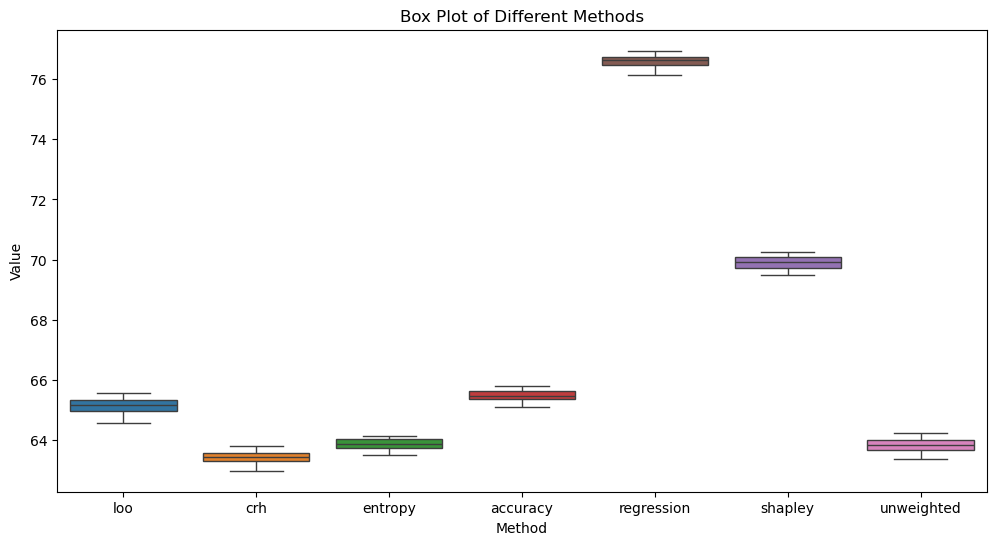

In [28]:
di_bordas_df_melted = di_bordas_df.melt(var_name='Method', value_name='Value')

# Define a custom color palette
palette = {
    'loo': '#1f77b4',        # Blue
    'crh': '#ff7f0e',        # Orange
    'entropy': '#2ca02c',    # Green
    'accuracy': '#d62728',   # Red
    'shapley': '#9467bd',    # Purple
    'regression': '#8c564b',  # Brown
    'unweighted': '#e377c2'  # Pink
}

# Create a box plot with the custom palette
plt.figure(figsize=(12, 6))
sns.boxplot(x='Method', y='Value', data=di_bordas_df_melted, palette=palette)
plt.title('Box Plot of Different Methods')
plt.ylabel('Value')
plt.xlabel('Method')
plt.show()